In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:100%!important;width:auto!important;}</style>"))

-------------------------------------------
<div>
<img src="https://www.bournemouth.ac.uk/sites/all/themes/bournemouth/assets/images/logo-horizontal.svg" width="200"/>
</div>

| Faculty of Science and Technology           |
| :-----------------------------------------: | 
| Department of Computing and Informatics     |
| Level 7 - Search and Optimisation - 2020/21 |
| Group No : 15 |

-----------------------------------------------

# **Problem1 definition:**
Optimum delivery plan for real-world LPG distributor is proposed in the following work. Customer location, fuel tank requirement, depot location, tanker lorry capacity and delivery cost details are given. The work aims to fulfil all customers fuel requirement with minimum delivery cost.


## Genetic algorithm:
Genetic algorithm gives optimum solution to the problem. It is random-based evolutionary algorithm. The process starts with set of solutions and keeps on iterating until find the optimum solution. The process consists five phases.


1.  Population: The algorithm starts with set of random expected solutions which is called as population. Each solution is individuals of the problem. Every solution having chromosome. Every chromosome consists genes(variable).
2.  Fitness: Every individual having fitness value. It shows the quality of each solution. Based on fitness score, individuals are selected to reproduction process. High scored individuals having maximum probability of selection. 
3. Selection: In this selection process, best high scored individual pairs are selected as parents to reproduce new generation off-spring children. Genes of two parent individuals are involved to produce two children with new set of genes.
4.  Crossover: Crossover is main step of genetic algorithm. In this stage, parent individual’s genes are interchanged until crossover point and produce offspring. Crossover point is selected randomly. New generation children having genes from their parent genes.
5.  Mutation: offspring genes are changed randomly to get quality solution.   











# **Coding explaination:**
>**Importing python libraries:** Python programming language is used for the optimization problem. Some library functions are imported.




In [2]:
import json
import networkx as nx
import pandas as pd
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import networkx as nx

Created classes for Customer, Lorry and Fitness

# Loading files
Given data files are simply loaded to df_loc, df_link, depot_lorries. And assigning columns to specific variables what we use.

In [3]:
# declare variables

ans=[] # To store final answers
cust_523=[] # To store all customer near by depot 523
cust_124=[] # To store all customer near by depot 124
cust_373=[] # To store all customer near by depot 373
cust_116=[] # To store all customer near by depot 116
df_loc=None # To store all location information from csv file
df_link=None # To store all links between differnet location
depot_lorries=None # To store all lorries
depot_loc_ids=None # Store only depot location
cust_loc_ids = None # Store only actual customer
juc_loc_ids = None # Store all juction 
remainingCustomer=None # Store all remaining customer to visit
allcustomerdistance=None # Distance matrix
edges=None # Edges between each location
G=None # For Graph
pos=None 
length=None 
dist_graph=None # Actual distance between two location 

In [4]:
# Clear all variable value
def clearAll():
    # Clear All
    global ans,cust_523,cust_124,cust_373,cust_116,df_loc,df_link,depot_lorries,depot_loc_ids, cust_loc_ids, juc_loc_ids,remainingCustomer,allcustomerdistance,edges,G,pos,length,dist_graph
    ans=[]
    cust_523=[]
    cust_124=[]
    cust_373=[]
    cust_116=[]
    df_loc=None
    df_link=None
    depot_lorries=None
    depot_loc_ids=None
    cust_loc_ids = None
    juc_loc_ids = None
    remainingCustomer=None
    allcustomerdistance=None
    edges=None
    G=None
    pos=None
    length=None
    dist_graph=None

In [5]:
# To load all required file
def loadFiles():
    global df_loc,df_link,depot_lorries
    # load all needed files and
    
    df_loc= pd.read_csv("../dataset/SaO_Optilandia_locations.csv")
    df_link = pd.read_csv("../dataset/SaO_Optilandia_links.csv")
    depot_lorries = json.load(open("../dataset/SaO_Optilandia_depot_lorries.json",'r'))

In [6]:
# Initialization 
def initializeGlobelVariable():
    global depot_loc_ids, cust_loc_ids, juc_loc_ids,remainingCustomer,allcustomerdistance,edges,G,pos,length,dist_graph
    depot_loc_ids, cust_loc_ids, juc_loc_ids =np.where(df_loc.is_depot)[0], np.where(df_loc.is_customer)[0], np.where((df_loc.is_depot == False) & (df_loc.is_customer == False))[0]
    remainingCustomer = cust_loc_ids.copy()
    allcustomerdistance = squareform(pdist(df_loc[['x', 'y']])) 
    edges  = [(id1, id2, allcustomerdistance[id1, id2]) for _, (id1, id2) in df_link.iterrows()]
    G = nx.Graph()
    G.add_nodes_from(range(len(df_loc)))
    G.add_weighted_edges_from(edges)
    pos={k:v.values for k,v in df_loc[['x', 'y']].iterrows()}
    #create a matrix which shows the shortest path between the nodes
    length = dict(nx.shortest_path_length(G, weight='weight'))
    dist_graph =  np.array([[length[i][j] for i in range(len(G.nodes))] for j in range(len(G.nodes))])

# Class

Classes are like objects. All they do structuring the given details with conditions.

**Customer Class:**
Functions will structuring a customer data which is given distance function find distance between two points using euclidean formula.

In [7]:
class Customer:
    def __init__(self,_id, x, y,capacity,level):
        self.id=_id
        self.x = x
        self.y = y
        self.capacity= capacity
        self.level = level
        self.required = (self.capacity - self.level)
    def distance(self, customer): # Calculated euclidean distance between two points  
        
        distance = dist_graph[int(self.id),int(customer.id)]     
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

**Lorry class:** 
Contains three functions.

1.   Structuring lorry details.
2.   Calculating a cost of delivery with conditions what given.
3.   function to updating fuel load after every delivery.


In [8]:
class Lorry:
    def __init__(self,_id,key,capacity,cpm,cptm,loaded):
        self.id=_id,
        self.key= key,
        self.capacity= capacity,
        self.cpm= cpm,
        self.cptm= cptm,
        self.loaded = loaded
    def cost(self,distance): # Calculate cost as distance * (cpm + requirement of gas)
            costvalue= distance * (self.cpm[0] + ( self.loaded * self.cptm[0]))
            return costvalue
    def remaining_loaded(self,delivered): # to check maximum gas limitation of lorry to deliver
            self.loaded -= delivered
            return self.loaded

**Fitness class:**
In our problem, we need to focus on both distance and cost. Routefitness function aims to acheive maximum delivery with minimum cost. 

In [9]:
class Fitness:
    def __init__(self, route):
        self.route = route        
        self.cost=0.0
    def routeFitness(self,lorry):        
        overallcost=0
        if self.cost ==0:
            pathCost = 0   
            # Lorry always start journy from depot so first time fromCustomer always be depot 
            for i in range(0, len(self.route)):
                if i==0:          # All lorries start their route from depot      
                    fromCustomer= Customer(int(lorry.key[0]),df_loc.loc[int(lorry.key[0])].x,df_loc.loc[int(lorry.key[0])].y,0.0,0.0) # Inititalize depot as customer
                else:
                    fromCustomer = self.route[i-1]
                toCustomer = self.route[i]
                lorry.remaining_loaded(toCustomer.required)
                pathCost += lorry.cost(fromCustomer.distance(toCustomer))  
            self.cost = pathCost #/ len(self.route)  To minimise cost of journy we check howmany miles lorry takes for howmany customer
        return self.cost,self.route    

In [10]:
# to store some data with the key value
class my_dictionary(dict): 
  
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

# **FUNCTIONS:**


**createJSONFile:**
Create json file

In [11]:
# Create json file for solution checker
def createJSONFile(data,cost):
    file_name = str(cost)+".json"
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)
    print("File save as "+file_name)
    return file_name

**TotalCapacity:**
Function which returns the capacity of lorry from the table.

In [12]:
# To check total capacity of lorries for perticular depot. Ex. totalCapacity(523) => 56
def totalCapacity(lorrynumber):
    cap = 0;
    for lorry in depot_lorries[str(lorrynumber)]:
        cap = cap + lorry['capacity'];
    return cap


>**K Nearest Neighbour algorithm (KNN):** KNN is the very popular algorithm used for classification problem in machine learning. It classifying dataset according to their distance which calculated by euclidean distance formula.

**GetCustomerList:**
Depot number and Area to cover are passed as a parameter. According that location details function returns customer list.

**GetSortestCustomer:**
Function returns nearest customers list for the particular lorry using dist_graph array.

We have used two functions getCustomerList and getSortestCustomer to devide all customer in each depots but after observing result we go with getSortestCustomer function 

In [13]:
# Get customer list on the basis of the area which we have assign 
# While initializing population we pass deport_number(int) and areaTocover (int).
# We add depot location by area_to_cover in 'x' and 'y' to expand area and cover alll customer within that area
# Ex. getCustomerList(523,250) then all customer within area of 250 up and down and 250 right and left
def getCustomerList(depot_number,area_to_cover):
    print("number =>" + str(depot_number))
    myx,myy=float(df_loc.loc[[depot_number]]['x']),float(df_loc.loc[[depot_number]]['y'])
    mycustomer =np.where((df_loc.x >=myx -area_to_cover) & (df_loc.x < myx+area_to_cover) & (df_loc.y >=myy -area_to_cover) & (df_loc.y < myy+area_to_cover) & (df_loc.is_customer == True))[0]
    loc_ = df_loc.loc[mycustomer]
    xyz=loc_[['id','x','y','capacity','level']].values.tolist()
    customer_list = []
    
    for i in xyz:
        if int(i[0]) in remainingCustomer:
            customer_list.append(Customer(_id=i[0],x=i[1], y=i[2], capacity=i[3], level=i[4]))
    return customer_list;
    


In [14]:
# Get all customer nearby the depot and store customers up to the deport capacity to deliver the GAS
# Ex. getSortestCustomer(523) => store all customers till total requrement of store customer less than 56 because 56 is total capacity of lorries of 523 depot
def getSortestCustomer(lorrynumber):
    global dist_graph;
    mycustomer = dist_graph[lorrynumber,:].argsort()
    loc_ = df_loc.loc[mycustomer[1:]]
    xyz=loc_[['id','x','y','capacity','level']].values.tolist()
    customer_list = []
    
    increment =0
    limit= totalCapacity(lorrynumber)
    for i in xyz:
        if int(i[0]) in remainingCustomer and increment < limit:
            increment= increment+1
            customer_list.append(Customer(_id=i[0],x=i[1], y=i[2], capacity=i[3], level=i[4]))
    return customer_list;

**MarkVisited:**
Function which delete customer from remainingCustomer list once we visited.

In [15]:
# Once we visited one customer we do not need to visite again 
def markVisited(item):  
    global remainingCustomer
    return np.delete(remainingCustomer, np.where(remainingCustomer == int(item)))

**CreateRoute:**
Function returns possible routes for particular lorry within the list.

In [16]:
# Create possible routes for given lorry
# We pass customer_list and randomly inititalize customer in individual and also check the capacity
def createRoute(customer_list,capacity):
    individual=[]    
    for element in range(0,len(customer_list)):
        index= random.randint(0,len(customer_list)-1)
        if customer_list[index] not in individual and capacity - customer_list[index].required > 0:
            capacity -=customer_list[index].required
            individual.append(customer_list[index])

    return individual

**InitialPopulation:**
For the given popsize, solution routes are created.

In [17]:
# Assign customer randomly for initial stage
# This is the first step of genetic algorithm to create initial population 
def initialPopulation(individual_size, customer_list,capacity):
    population = []
   
    for i in range(0, individual_size):
        population.append(createRoute(customer_list,capacity))
    return population

**RankRoutes:**
According to the cost of delivery of each route, fuction assigns rank to each.

In [18]:
# Calculate the cost of each routes and assign ranking so we can select best amoing them
def rankRoutes(population,lorry):
    cost={}
#     fitnessResults = {}   
    
    for i in range(0,len(population)):
        currentLorry=Lorry(_id= lorry.id[0],key=lorry.key[0],
                                             capacity=lorry.capacity[0],
                                             cpm=lorry.cpm[0],
                                             cptm=lorry.cptm[0],
                                             loaded=lorry.loaded)
        cost[i],population[i] = Fitness(population[i]).routeFitness(currentLorry)
    return sorted(cost.items(), key = operator.itemgetter(1), reverse = False),population # sorting becuase we need to minimize the cost of lorry

**Similler:**
Function to check array repeatations.

In [19]:
# To check whether both array are similler or not
def similler(array1,array2):
    result=[];
    for i in range(0, len(array1)):
        for j in range(0,len(array2)):
            if array1[i] == array2[j]:
                result.append(array1[i])
    return result;
            

**Crossover:**
Crossover is the important step in genetic algorithm. Here, parent1 and parent2 are invloving in crossover. Capacity is the crossover point. Upto crossover point parent genes are interchanged and give new child.


# Perform crossover
def crossover(parent1, parent2,capacity):
    child = []
    break_point = int(random.random() * len(parent1))
    for i in range(0, break_point):
        if capacity - parent1[i].required >0:
            child.append(parent1[i])
            capacity -= parent1[i].required
            
    for j in range(break_point,len(parent2)):
        if capacity - parent2[j].required >0 and parent2[j] not in childP1:
            child.append(parent2[j])
            capacity -= parent2[j].required

    return child

In [20]:
# Perform crossover
# Ex. parent1=[70,452,12,87,98,58] parent2=[65,25,78,45,213] 
# start_gene =2 and end_gene=4
# child =[12,87] parent 1,[65,25,78,45,113] parent 2 till max capacity
def crossover(parent1, parent2,capacity):
    child = []
    
    first_child = []
    second_child = []
    
    genea = int(random.random() * len(parent1))
    geneb = int(random.random() * len(parent1))
    
    start_gene = min(genea, geneb)
    end_gene = max(genea, geneb)

    for i in range(start_gene, end_gene):
        if capacity - parent1[i].required >0:
            first_child.append(parent1[i])
            capacity -= parent1[i].required
            
    for item in parent2:
        if capacity - item.required >0 and item not in first_child:
            second_child.append(item)
            capacity -= item.required
   

    child = first_child + second_child
    return child

**CrossoverPopulation:**
Crossover is done with our final newpopulation list. Here, finalised best routes are involving in crossover and produce new routes as child.

In [21]:
# create cross over population
def crossoverPopulation(new_population, elite_size, capacity):
    children = []
    length = len(new_population) - elite_size
    pool = random.sample(new_population, len(new_population))

    for i in range(0,elite_size): # elite_size to get all first individuals with out crossover
        children.append(new_population[i])
    
    for i in range(0, length):
        child = crossover(pool[i], pool[len(new_population)-i-1],capacity)
        children.append(child)
    return children

**Mutation:**
Without mutation, crossovered children are same as parent. Mutate function randomly change the genes of child with respect to minimum mutationRate.

In [22]:
# Perform mutation
# It swap two individuals
def mutate(individual, mutation_rate):
    for swapped in range(len(individual)):
        if(random.random() < mutation_rate):
            swapWith = int(random.random() * len(individual))
            
            first_customer = individual[swapped]
            second_customer= individual[swapWith]
            
            individual[swapped] = second_customer
            individual[swapWith] = first_customer
    return individual

**MutatePopulation:**
Mutation is performed in every population.

In [23]:
def mutatePopulation(population, mutation_rate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutation_rate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

**NextGeneration:**
Function which performs full genetic algorithm steps. From initial population, function finds new generation individuals by ranking routes, selecting best routes, generate child by crossover and finally mutating. 

In [24]:
a=[1,2,3]
np.cumsum(a)*100/np.sum(a)

array([ 16.66666667,  50.        , 100.        ])

In [25]:
# Select next generation
def nextGeneration(current_generation, elite_size, mutation_rate,lorry):
    selection_results = [] # To select individual from new population
    new_population = [] # To store new population 

#SELECT parents
    
    pop_ranked,next_population = rankRoutes(current_generation,lorry)
#     selectionResults = selectIndividuals(popRanked, eliteSize)
    
    df = pd.DataFrame(np.array(pop_ranked), columns=["Index","Fitness"])
    df['csum'] = df.Fitness.cumsum()  # a=[1,2,3] => [1,3,6]
    df['cperc'] = 100*df.csum/df.Fitness.sum()  # a=[1,2,3] = > [16.66, 50, 100]
    df.sort_values(by=['Fitness'], ascending=False) # We need to minimize, for above example we need 16.66 

    for i in range(0, elite_size):
        selection_results.append(pop_ranked[i][0])
    for i in range(0, len(pop_ranked) - elite_size):
        pick = random.randint(0,50)
        for i in range(0, len(pop_ranked)): 
            if pick <= df.iat[i,3]:
                selection_results.append(pop_ranked[i][0])
                break
            
#     newPopulation = generatePopulation(current_generation, selectionResults)  

    for i in range(0, len(selection_results)):
        index = selection_results[i]
        new_population.append(current_generation[index])
        
#RECOMBINE pairs of  parents:

    children = crossoverPopulation(new_population, elite_size, lorry.capacity[0])
    
#MUTATE the resulting offspring:
    
    next_generation = mutatePopulation(children, mutation_rate)
    
    return next_generation

**Genetic Algorithm:**
For problem optimisation, customers are clustered with respect to depot. KNN algorithm is used for clustering a customers. within the customer list genetic algorithm is used to find the best new generation population(routes). From next generation po[pulation, optimum route is finalised.

In [27]:
def geneticAlgorithm(individual_size, eliteSize, mutation_rate, generations):
    
    totalcost=0 # total cost
    totalprogress=[] # To plot the graph
    my_dict = my_dictionary() # To formate the output
    # use of globel variables
    global ans
    global remainingCustomer
    global AllGenesDistance
    
    #Begin
    
    for limit in range(0,11): # rane(0,11) beacuse our 373 depot have 10 lorrries 
        for e in depot_lorries.items():
            if(len(e[1]) > limit):
                each=e[1][limit] # lorry => {'lorry_id': '523-0', 'capacity': 5, 'cpm': 1.0, 'cptm': 1.5}
                lorry=Lorry(_id= each['lorry_id'],key=int(e[0]),
                                                 capacity=each['capacity'],
                                                 cpm=each['cpm'],
                                                 cptm=each['cptm'],
                                                 loaded=each['capacity']) # create lorry class object
                
    # INITIALISE population with random candidate solution:  
    
                iPopulation =getSortestCustomer(int(e[0])) 
     
                customerVisited=[] # visited customer for perticular lorry 
                progress=[]
                customerVisited.append([int(lorry.key[0]),lorry.capacity[0]])
                if len(iPopulation) > 0:  
    
    #EVALUATE each candidate:
    
                    pop = initialPopulation(individual_size, iPopulation,lorry.capacity[0])
                    initialRankRoutes,population= rankRoutes(pop,lorry)            
                    print("Initial cost: " + str(initialRankRoutes[0][1]))
                    progress.append(initialRankRoutes[0][1])
                    currentbestvalue=initialRankRoutes[0][1];
                    bestRouteIndex = initialRankRoutes[0][0]
                    bestRoute = population[bestRouteIndex]
                    
    #REPEAT UNTILL ( TEMINATION CONDITION is satisfied )
    
                    for i in range(0, generations):

    #EVALUATE new candidates
    
                        pop = nextGeneration(pop, eliteSize, mutation_rate,lorry)
                        finalRankRoutes,finalPopulation= rankRoutes(pop,lorry)
            
    #SELECT individuals for next generation:
    
                        if currentbestvalue > finalRankRoutes[0][1]:
                            currentbestvalue = finalRankRoutes[0][1]
                            bestRouteIndex = finalRankRoutes[0][0]
                            bestRoute = finalPopulation[bestRouteIndex]
                        print(str(i) + " Generation cost: " + str(finalRankRoutes[0][1]))
                        progress.append(finalRankRoutes[0][1])
                    totalcost= totalcost + finalRankRoutes[0][1]
                    for item in pop[finalRankRoutes[0][0]]: 
                        remainingCustomer=markVisited(item.id)
                        dist_graph[int(e[0]),int(item.id)] = 2000 # try to initialize maximum number
                        customerVisited.append([int(item.id),(float(item.required)-(2 * float(item.required)))])
                        
                e[1][limit]['capacity']=0
                customerVisited.append([depot_loc_ids[dist_graph[customerVisited[-1][0],depot_loc_ids].argsort()[0]],0])
                my_dict.add(lorry.id[0],progress) 
                ans.append({"lorry_id": lorry.id[0], "loc": customerVisited})
                
    #END  
    
    return ans,totalcost,my_dict

In [52]:
remainingCustomer

array([], dtype=int64)

# **FUNCTIONS CALL:**
    

In [47]:
clearAll()

In [48]:
loadFiles()

In [49]:
initializeGlobelVariable()

>**Call geneticAlgorithm ans store all outputs:** 

*   output: store output in json format 
*   totalcost: total coast
*   mydict: Use to display output

In [50]:
%%time
output,totalcost,mydict=geneticAlgorithm(individual_size=100, eliteSize=20, mutation_rate=0.02, generations=100)

Initial cost: 3314.443753763855
0 Generation cost: 3314.443753763855
1 Generation cost: 1919.4233214078295
2 Generation cost: 1976.2784751086706
3 Generation cost: 1976.2784751086706
4 Generation cost: 1757.075672637094
5 Generation cost: 1406.464019676744
6 Generation cost: 1406.464019676744
7 Generation cost: 1201.6230922478726
8 Generation cost: 1201.6230922478726
9 Generation cost: 1201.6230922478726
10 Generation cost: 1066.329205505208
11 Generation cost: 1066.329205505208
12 Generation cost: 1066.329205505208
13 Generation cost: 1066.329205505208
14 Generation cost: 1066.329205505208
15 Generation cost: 1066.329205505208
16 Generation cost: 1066.329205505208
17 Generation cost: 1066.329205505208
18 Generation cost: 1030.391855212518
19 Generation cost: 1005.1713103411233
20 Generation cost: 1005.1713103411233
21 Generation cost: 1005.1713103411233
22 Generation cost: 1005.1713103411233
23 Generation cost: 1005.1713103411233
24 Generation cost: 1005.1713103411233
25 Generation co

208 Generation cost: 1005.1713103411233
209 Generation cost: 1005.1713103411233
210 Generation cost: 1005.1713103411233
211 Generation cost: 1005.1713103411233
212 Generation cost: 1005.1713103411233
213 Generation cost: 1005.1713103411233
214 Generation cost: 1005.1713103411233
215 Generation cost: 1005.1713103411233
216 Generation cost: 1005.1713103411233
217 Generation cost: 1005.1713103411233
218 Generation cost: 1005.1713103411233
219 Generation cost: 1005.1713103411233
220 Generation cost: 1005.1713103411233
221 Generation cost: 1005.1713103411233
222 Generation cost: 1005.1713103411233
223 Generation cost: 1005.1713103411233
224 Generation cost: 1005.1713103411233
225 Generation cost: 1005.1713103411233
226 Generation cost: 1005.1713103411233
227 Generation cost: 1005.1713103411233
228 Generation cost: 1005.1713103411233
229 Generation cost: 1005.1713103411233
230 Generation cost: 1005.1713103411233
231 Generation cost: 1005.1713103411233
232 Generation cost: 1005.1713103411233


413 Generation cost: 1005.1713103411233
414 Generation cost: 1005.1713103411233
415 Generation cost: 1005.1713103411233
416 Generation cost: 1005.1713103411233
417 Generation cost: 1005.1713103411233
418 Generation cost: 1005.1713103411233
419 Generation cost: 1005.1713103411233
420 Generation cost: 1005.1713103411233
421 Generation cost: 1005.1713103411233
422 Generation cost: 1005.1713103411233
423 Generation cost: 1005.1713103411233
424 Generation cost: 1005.1713103411233
425 Generation cost: 1005.1713103411233
426 Generation cost: 1005.1713103411233
427 Generation cost: 1005.1713103411233
428 Generation cost: 1005.1713103411233
429 Generation cost: 1005.1713103411233
430 Generation cost: 1005.1713103411233
431 Generation cost: 1005.1713103411233
432 Generation cost: 1005.1713103411233
433 Generation cost: 1005.1713103411233
434 Generation cost: 1005.1713103411233
435 Generation cost: 1005.1713103411233
436 Generation cost: 1005.1713103411233
437 Generation cost: 1005.1713103411233


128 Generation cost: 777.628432368112
129 Generation cost: 777.628432368112
130 Generation cost: 777.628432368112
131 Generation cost: 777.628432368112
132 Generation cost: 777.628432368112
133 Generation cost: 777.628432368112
134 Generation cost: 777.628432368112
135 Generation cost: 777.628432368112
136 Generation cost: 777.628432368112
137 Generation cost: 777.628432368112
138 Generation cost: 777.628432368112
139 Generation cost: 777.628432368112
140 Generation cost: 777.628432368112
141 Generation cost: 777.628432368112
142 Generation cost: 777.628432368112
143 Generation cost: 777.628432368112
144 Generation cost: 777.628432368112
145 Generation cost: 777.628432368112
146 Generation cost: 777.628432368112
147 Generation cost: 777.628432368112
148 Generation cost: 777.628432368112
149 Generation cost: 777.628432368112
150 Generation cost: 777.628432368112
151 Generation cost: 777.628432368112
152 Generation cost: 777.628432368112
153 Generation cost: 777.628432368112
154 Generati

347 Generation cost: 777.628432368112
348 Generation cost: 777.628432368112
349 Generation cost: 777.628432368112
350 Generation cost: 777.628432368112
351 Generation cost: 777.628432368112
352 Generation cost: 777.628432368112
353 Generation cost: 777.628432368112
354 Generation cost: 777.628432368112
355 Generation cost: 777.628432368112
356 Generation cost: 777.628432368112
357 Generation cost: 777.628432368112
358 Generation cost: 777.628432368112
359 Generation cost: 777.628432368112
360 Generation cost: 777.628432368112
361 Generation cost: 777.628432368112
362 Generation cost: 777.628432368112
363 Generation cost: 777.628432368112
364 Generation cost: 777.628432368112
365 Generation cost: 777.628432368112
366 Generation cost: 777.628432368112
367 Generation cost: 777.628432368112
368 Generation cost: 777.628432368112
369 Generation cost: 777.628432368112
370 Generation cost: 777.628432368112
371 Generation cost: 777.628432368112
372 Generation cost: 777.628432368112
373 Generati

61 Generation cost: 1298.9074459769022
62 Generation cost: 1298.9074459769022
63 Generation cost: 1298.9074459769022
64 Generation cost: 1298.9074459769022
65 Generation cost: 1298.9074459769022
66 Generation cost: 1298.9074459769022
67 Generation cost: 1298.9074459769022
68 Generation cost: 1298.9074459769022
69 Generation cost: 1298.9074459769022
70 Generation cost: 1298.9074459769022
71 Generation cost: 1298.9074459769022
72 Generation cost: 1298.9074459769022
73 Generation cost: 1298.9074459769022
74 Generation cost: 1298.9074459769022
75 Generation cost: 1298.9074459769022
76 Generation cost: 1298.9074459769022
77 Generation cost: 1298.9074459769022
78 Generation cost: 1298.9074459769022
79 Generation cost: 1298.9074459769022
80 Generation cost: 1298.9074459769022
81 Generation cost: 1298.9074459769022
82 Generation cost: 1298.9074459769022
83 Generation cost: 1298.9074459769022
84 Generation cost: 1298.9074459769022
85 Generation cost: 1298.9074459769022
86 Generation cost: 1298.

268 Generation cost: 1298.9074459769022
269 Generation cost: 1298.9074459769022
270 Generation cost: 1298.9074459769022
271 Generation cost: 1298.9074459769022
272 Generation cost: 1298.9074459769022
273 Generation cost: 1298.9074459769022
274 Generation cost: 1298.9074459769022
275 Generation cost: 1298.9074459769022
276 Generation cost: 1298.9074459769022
277 Generation cost: 1298.9074459769022
278 Generation cost: 1298.9074459769022
279 Generation cost: 1298.9074459769022
280 Generation cost: 1298.9074459769022
281 Generation cost: 1298.9074459769022
282 Generation cost: 1298.9074459769022
283 Generation cost: 1298.9074459769022
284 Generation cost: 1298.9074459769022
285 Generation cost: 1298.9074459769022
286 Generation cost: 1298.9074459769022
287 Generation cost: 1298.9074459769022
288 Generation cost: 1298.9074459769022
289 Generation cost: 1298.9074459769022
290 Generation cost: 1298.9074459769022
291 Generation cost: 1298.9074459769022
292 Generation cost: 1298.9074459769022


474 Generation cost: 1298.9074459769022
475 Generation cost: 1298.9074459769022
476 Generation cost: 1298.9074459769022
477 Generation cost: 1298.9074459769022
478 Generation cost: 1298.9074459769022
479 Generation cost: 1298.9074459769022
480 Generation cost: 1298.9074459769022
481 Generation cost: 1298.9074459769022
482 Generation cost: 1298.9074459769022
483 Generation cost: 1298.9074459769022
484 Generation cost: 1298.9074459769022
485 Generation cost: 1298.9074459769022
486 Generation cost: 1298.9074459769022
487 Generation cost: 1298.9074459769022
488 Generation cost: 1298.9074459769022
489 Generation cost: 1298.9074459769022
490 Generation cost: 1298.9074459769022
491 Generation cost: 1298.9074459769022
492 Generation cost: 1298.9074459769022
493 Generation cost: 1298.9074459769022
494 Generation cost: 1298.9074459769022
495 Generation cost: 1298.9074459769022
496 Generation cost: 1298.9074459769022
497 Generation cost: 1298.9074459769022
498 Generation cost: 1298.9074459769022


188 Generation cost: 884.8662990839343
189 Generation cost: 884.8662990839343
190 Generation cost: 884.8662990839343
191 Generation cost: 884.8662990839343
192 Generation cost: 884.8662990839343
193 Generation cost: 884.8662990839343
194 Generation cost: 884.8662990839343
195 Generation cost: 884.8662990839343
196 Generation cost: 884.8662990839343
197 Generation cost: 884.8662990839343
198 Generation cost: 884.8662990839343
199 Generation cost: 884.8662990839343
200 Generation cost: 884.8662990839343
201 Generation cost: 884.8662990839343
202 Generation cost: 884.8662990839343
203 Generation cost: 884.8662990839343
204 Generation cost: 884.8662990839343
205 Generation cost: 884.8662990839343
206 Generation cost: 884.8662990839343
207 Generation cost: 884.8662990839343
208 Generation cost: 884.8662990839343
209 Generation cost: 884.8662990839343
210 Generation cost: 884.8662990839343
211 Generation cost: 884.8662990839343
212 Generation cost: 884.8662990839343
213 Generation cost: 884.

399 Generation cost: 884.8662990839343
400 Generation cost: 884.8662990839343
401 Generation cost: 884.8662990839343
402 Generation cost: 884.8662990839343
403 Generation cost: 884.8662990839343
404 Generation cost: 884.8662990839343
405 Generation cost: 884.8662990839343
406 Generation cost: 884.8662990839343
407 Generation cost: 884.8662990839343
408 Generation cost: 884.8662990839343
409 Generation cost: 884.8662990839343
410 Generation cost: 884.8662990839343
411 Generation cost: 884.8662990839343
412 Generation cost: 884.8662990839343
413 Generation cost: 884.8662990839343
414 Generation cost: 884.8662990839343
415 Generation cost: 884.8662990839343
416 Generation cost: 884.8662990839343
417 Generation cost: 884.8662990839343
418 Generation cost: 884.8662990839343
419 Generation cost: 884.8662990839343
420 Generation cost: 884.8662990839343
421 Generation cost: 884.8662990839343
422 Generation cost: 884.8662990839343
423 Generation cost: 884.8662990839343
424 Generation cost: 884.

111 Generation cost: 1743.3219079241055
112 Generation cost: 1743.3219079241055
113 Generation cost: 1743.3219079241055
114 Generation cost: 1743.3219079241055
115 Generation cost: 1743.3219079241055
116 Generation cost: 1743.3219079241055
117 Generation cost: 1743.3219079241055
118 Generation cost: 1743.3219079241055
119 Generation cost: 1743.3219079241055
120 Generation cost: 1743.3219079241055
121 Generation cost: 1743.3219079241055
122 Generation cost: 1743.3219079241055
123 Generation cost: 1743.3219079241055
124 Generation cost: 1743.3219079241055
125 Generation cost: 1743.3219079241055
126 Generation cost: 1743.3219079241055
127 Generation cost: 1743.3219079241055
128 Generation cost: 1743.3219079241055
129 Generation cost: 1743.3219079241055
130 Generation cost: 1743.3219079241055
131 Generation cost: 1743.3219079241055
132 Generation cost: 1743.3219079241055
133 Generation cost: 1743.3219079241055
134 Generation cost: 1743.3219079241055
135 Generation cost: 1743.3219079241055


318 Generation cost: 1743.3219079241055
319 Generation cost: 1743.3219079241055
320 Generation cost: 1743.3219079241055
321 Generation cost: 1743.3219079241055
322 Generation cost: 1743.3219079241055
323 Generation cost: 1743.3219079241055
324 Generation cost: 1743.3219079241055
325 Generation cost: 1743.3219079241055
326 Generation cost: 1743.3219079241055
327 Generation cost: 1743.3219079241055
328 Generation cost: 1743.3219079241055
329 Generation cost: 1743.3219079241055
330 Generation cost: 1743.3219079241055
331 Generation cost: 1743.3219079241055
332 Generation cost: 1743.3219079241055
333 Generation cost: 1743.3219079241055
334 Generation cost: 1743.3219079241055
335 Generation cost: 1743.3219079241055
336 Generation cost: 1743.3219079241055
337 Generation cost: 1743.3219079241055
338 Generation cost: 1743.3219079241055
339 Generation cost: 1743.3219079241055
340 Generation cost: 1743.3219079241055
341 Generation cost: 1743.3219079241055
342 Generation cost: 1743.3219079241055


24 Generation cost: 880.46547283654
25 Generation cost: 880.46547283654
26 Generation cost: 880.46547283654
27 Generation cost: 880.46547283654
28 Generation cost: 880.46547283654
29 Generation cost: 880.46547283654
30 Generation cost: 880.46547283654
31 Generation cost: 880.46547283654
32 Generation cost: 880.46547283654
33 Generation cost: 880.46547283654
34 Generation cost: 880.46547283654
35 Generation cost: 880.46547283654
36 Generation cost: 880.46547283654
37 Generation cost: 880.46547283654
38 Generation cost: 880.46547283654
39 Generation cost: 880.46547283654
40 Generation cost: 880.46547283654
41 Generation cost: 880.46547283654
42 Generation cost: 880.46547283654
43 Generation cost: 880.46547283654
44 Generation cost: 880.46547283654
45 Generation cost: 880.46547283654
46 Generation cost: 880.46547283654
47 Generation cost: 880.46547283654
48 Generation cost: 880.46547283654
49 Generation cost: 880.46547283654
50 Generation cost: 880.46547283654
51 Generation cost: 880.4654

248 Generation cost: 880.46547283654
249 Generation cost: 880.46547283654
250 Generation cost: 880.46547283654
251 Generation cost: 880.46547283654
252 Generation cost: 880.46547283654
253 Generation cost: 880.46547283654
254 Generation cost: 880.46547283654
255 Generation cost: 880.46547283654
256 Generation cost: 880.46547283654
257 Generation cost: 880.46547283654
258 Generation cost: 880.46547283654
259 Generation cost: 880.46547283654
260 Generation cost: 880.46547283654
261 Generation cost: 880.46547283654
262 Generation cost: 880.46547283654
263 Generation cost: 880.46547283654
264 Generation cost: 880.46547283654
265 Generation cost: 880.46547283654
266 Generation cost: 880.46547283654
267 Generation cost: 880.46547283654
268 Generation cost: 880.46547283654
269 Generation cost: 880.46547283654
270 Generation cost: 880.46547283654
271 Generation cost: 880.46547283654
272 Generation cost: 880.46547283654
273 Generation cost: 880.46547283654
274 Generation cost: 880.46547283654
2

472 Generation cost: 880.46547283654
473 Generation cost: 880.46547283654
474 Generation cost: 880.46547283654
475 Generation cost: 880.46547283654
476 Generation cost: 880.46547283654
477 Generation cost: 880.46547283654
478 Generation cost: 880.46547283654
479 Generation cost: 880.46547283654
480 Generation cost: 880.46547283654
481 Generation cost: 880.46547283654
482 Generation cost: 880.46547283654
483 Generation cost: 880.46547283654
484 Generation cost: 880.46547283654
485 Generation cost: 880.46547283654
486 Generation cost: 880.46547283654
487 Generation cost: 880.46547283654
488 Generation cost: 880.46547283654
489 Generation cost: 880.46547283654
490 Generation cost: 880.46547283654
491 Generation cost: 880.46547283654
492 Generation cost: 880.46547283654
493 Generation cost: 880.46547283654
494 Generation cost: 880.46547283654
495 Generation cost: 880.46547283654
496 Generation cost: 880.46547283654
497 Generation cost: 880.46547283654
498 Generation cost: 880.46547283654
4

190 Generation cost: 2036.666064672976
191 Generation cost: 2036.666064672976
192 Generation cost: 2036.666064672976
193 Generation cost: 2036.666064672976
194 Generation cost: 2036.666064672976
195 Generation cost: 2036.666064672976
196 Generation cost: 2036.666064672976
197 Generation cost: 2036.666064672976
198 Generation cost: 2036.666064672976
199 Generation cost: 2036.666064672976
200 Generation cost: 2036.666064672976
201 Generation cost: 2036.666064672976
202 Generation cost: 2036.666064672976
203 Generation cost: 2036.666064672976
204 Generation cost: 2036.666064672976
205 Generation cost: 2036.666064672976
206 Generation cost: 2036.666064672976
207 Generation cost: 2036.666064672976
208 Generation cost: 2036.666064672976
209 Generation cost: 2036.666064672976
210 Generation cost: 2036.666064672976
211 Generation cost: 2036.666064672976
212 Generation cost: 2036.666064672976
213 Generation cost: 2036.666064672976
214 Generation cost: 2036.666064672976
215 Generation cost: 2036

401 Generation cost: 2036.666064672976
402 Generation cost: 2036.666064672976
403 Generation cost: 2036.666064672976
404 Generation cost: 2036.666064672976
405 Generation cost: 2036.666064672976
406 Generation cost: 2036.666064672976
407 Generation cost: 2036.666064672976
408 Generation cost: 2036.666064672976
409 Generation cost: 2036.666064672976
410 Generation cost: 2036.666064672976
411 Generation cost: 2036.666064672976
412 Generation cost: 2036.666064672976
413 Generation cost: 2036.666064672976
414 Generation cost: 2036.666064672976
415 Generation cost: 2036.666064672976
416 Generation cost: 2036.666064672976
417 Generation cost: 2036.666064672976
418 Generation cost: 2036.666064672976
419 Generation cost: 2036.666064672976
420 Generation cost: 2036.666064672976
421 Generation cost: 2036.666064672976
422 Generation cost: 2036.666064672976
423 Generation cost: 2036.666064672976
424 Generation cost: 2036.666064672976
425 Generation cost: 2036.666064672976
426 Generation cost: 2036

115 Generation cost: 5019.185140905903
116 Generation cost: 5019.185140905903
117 Generation cost: 5019.185140905903
118 Generation cost: 5019.185140905903
119 Generation cost: 5019.185140905903
120 Generation cost: 5019.185140905903
121 Generation cost: 5019.185140905903
122 Generation cost: 5019.185140905903
123 Generation cost: 5019.185140905903
124 Generation cost: 5019.185140905903
125 Generation cost: 5019.185140905903
126 Generation cost: 5019.185140905903
127 Generation cost: 5019.185140905903
128 Generation cost: 5019.185140905903
129 Generation cost: 5019.185140905903
130 Generation cost: 5019.185140905903
131 Generation cost: 5019.185140905903
132 Generation cost: 5019.185140905903
133 Generation cost: 5019.185140905903
134 Generation cost: 5019.185140905903
135 Generation cost: 5019.185140905903
136 Generation cost: 5019.185140905903
137 Generation cost: 5019.185140905903
138 Generation cost: 5019.185140905903
139 Generation cost: 5019.185140905903
140 Generation cost: 5019

326 Generation cost: 5019.185140905903
327 Generation cost: 5019.185140905903
328 Generation cost: 5019.185140905903
329 Generation cost: 5019.185140905903
330 Generation cost: 5019.185140905903
331 Generation cost: 5019.185140905903
332 Generation cost: 5019.185140905903
333 Generation cost: 5019.185140905903
334 Generation cost: 5019.185140905903
335 Generation cost: 5019.185140905903
336 Generation cost: 5019.185140905903
337 Generation cost: 5019.185140905903
338 Generation cost: 5019.185140905903
339 Generation cost: 5019.185140905903
340 Generation cost: 5019.185140905903
341 Generation cost: 5019.185140905903
342 Generation cost: 5019.185140905903
343 Generation cost: 5019.185140905903
344 Generation cost: 5019.185140905903
345 Generation cost: 5019.185140905903
346 Generation cost: 5019.185140905903
347 Generation cost: 5019.185140905903
348 Generation cost: 5019.185140905903
349 Generation cost: 5019.185140905903
350 Generation cost: 5019.185140905903
351 Generation cost: 5019

36 Generation cost: 11706.680687059688
37 Generation cost: 11557.223736957567
38 Generation cost: 11375.583715319246
39 Generation cost: 10285.441522382607
40 Generation cost: 10285.441522382607
41 Generation cost: 10285.441522382607
42 Generation cost: 10285.441522382607
43 Generation cost: 10285.441522382607
44 Generation cost: 10382.592828416486
45 Generation cost: 10382.592828416486
46 Generation cost: 9961.631634627265
47 Generation cost: 9961.631634627265
48 Generation cost: 9961.631634627265
49 Generation cost: 9755.279452113899
50 Generation cost: 9961.631634627265
51 Generation cost: 9961.631634627265
52 Generation cost: 10119.826945247452
53 Generation cost: 10119.826945247452
54 Generation cost: 10093.273168948035
55 Generation cost: 9952.932958900326
56 Generation cost: 9952.932958900326
57 Generation cost: 9952.932958900326
58 Generation cost: 9755.279452113899
59 Generation cost: 9755.279452113899
60 Generation cost: 9755.279452113899
61 Generation cost: 9755.279452113899

248 Generation cost: 9508.213954908768
249 Generation cost: 9508.213954908768
250 Generation cost: 9508.213954908768
251 Generation cost: 9508.213954908768
252 Generation cost: 9508.213954908768
253 Generation cost: 9508.213954908768
254 Generation cost: 9508.213954908768
255 Generation cost: 9508.213954908768
256 Generation cost: 9508.213954908768
257 Generation cost: 9508.213954908768
258 Generation cost: 9508.213954908768
259 Generation cost: 9508.213954908768
260 Generation cost: 9508.213954908768
261 Generation cost: 9508.213954908768
262 Generation cost: 9508.213954908768
263 Generation cost: 9508.213954908768
264 Generation cost: 9508.213954908768
265 Generation cost: 9508.213954908768
266 Generation cost: 9508.213954908768
267 Generation cost: 9508.213954908768
268 Generation cost: 9508.213954908768
269 Generation cost: 9508.213954908768
270 Generation cost: 9508.213954908768
271 Generation cost: 9508.213954908768
272 Generation cost: 9508.213954908768
273 Generation cost: 9508

459 Generation cost: 9523.104762539686
460 Generation cost: 9523.104762539686
461 Generation cost: 9523.104762539686
462 Generation cost: 9523.104762539686
463 Generation cost: 9508.213954908768
464 Generation cost: 9508.213954908768
465 Generation cost: 9508.213954908768
466 Generation cost: 9508.213954908768
467 Generation cost: 9508.213954908768
468 Generation cost: 9508.213954908768
469 Generation cost: 9508.213954908768
470 Generation cost: 9508.213954908768
471 Generation cost: 9508.213954908768
472 Generation cost: 9508.213954908768
473 Generation cost: 9508.213954908768
474 Generation cost: 9508.213954908768
475 Generation cost: 9508.213954908768
476 Generation cost: 9508.213954908768
477 Generation cost: 9508.213954908768
478 Generation cost: 9508.213954908768
479 Generation cost: 9508.213954908768
480 Generation cost: 9508.213954908768
481 Generation cost: 9508.213954908768
482 Generation cost: 9508.213954908768
483 Generation cost: 9508.213954908768
484 Generation cost: 9508

169 Generation cost: 1011.9667902393177
170 Generation cost: 1011.9667902393177
171 Generation cost: 1011.9667902393177
172 Generation cost: 1011.9667902393177
173 Generation cost: 1011.9667902393177
174 Generation cost: 1011.9667902393177
175 Generation cost: 1011.9667902393177
176 Generation cost: 1011.9667902393177
177 Generation cost: 1011.9667902393177
178 Generation cost: 1011.9667902393177
179 Generation cost: 1011.9667902393177
180 Generation cost: 1011.9667902393177
181 Generation cost: 1011.9667902393177
182 Generation cost: 1011.9667902393177
183 Generation cost: 1011.9667902393177
184 Generation cost: 1011.9667902393177
185 Generation cost: 1011.9667902393177
186 Generation cost: 1011.9667902393177
187 Generation cost: 1011.9667902393177
188 Generation cost: 1011.9667902393177
189 Generation cost: 1011.9667902393177
190 Generation cost: 1011.9667902393177
191 Generation cost: 1011.9667902393177
192 Generation cost: 1011.9667902393177
193 Generation cost: 1011.9667902393177


375 Generation cost: 1011.9667902393177
376 Generation cost: 1011.9667902393177
377 Generation cost: 1011.9667902393177
378 Generation cost: 1011.9667902393177
379 Generation cost: 1011.9667902393177
380 Generation cost: 1011.9667902393177
381 Generation cost: 1011.9667902393177
382 Generation cost: 1011.9667902393177
383 Generation cost: 1011.9667902393177
384 Generation cost: 1011.9667902393177
385 Generation cost: 1011.9667902393177
386 Generation cost: 1011.9667902393177
387 Generation cost: 1011.9667902393177
388 Generation cost: 1011.9667902393177
389 Generation cost: 1011.9667902393177
390 Generation cost: 1011.9667902393177
391 Generation cost: 1011.9667902393177
392 Generation cost: 1011.9667902393177
393 Generation cost: 1011.9667902393177
394 Generation cost: 1011.9667902393177
395 Generation cost: 1011.9667902393177
396 Generation cost: 1011.9667902393177
397 Generation cost: 1011.9667902393177
398 Generation cost: 1011.9667902393177
399 Generation cost: 1011.9667902393177


84 Generation cost: 2457.353835433844
85 Generation cost: 2457.353835433844
86 Generation cost: 2457.353835433844
87 Generation cost: 2457.353835433844
88 Generation cost: 2457.353835433844
89 Generation cost: 2457.353835433844
90 Generation cost: 2457.353835433844
91 Generation cost: 2457.353835433844
92 Generation cost: 2457.353835433844
93 Generation cost: 2457.353835433844
94 Generation cost: 2457.353835433844
95 Generation cost: 2457.353835433844
96 Generation cost: 2457.353835433844
97 Generation cost: 2457.353835433844
98 Generation cost: 2457.353835433844
99 Generation cost: 2457.353835433844
100 Generation cost: 2457.353835433844
101 Generation cost: 2457.353835433844
102 Generation cost: 2457.353835433844
103 Generation cost: 2457.353835433844
104 Generation cost: 2457.353835433844
105 Generation cost: 2457.353835433844
106 Generation cost: 2457.353835433844
107 Generation cost: 2457.353835433844
108 Generation cost: 2457.353835433844
109 Generation cost: 2457.353835433844
11

296 Generation cost: 2457.353835433844
297 Generation cost: 2457.353835433844
298 Generation cost: 2457.353835433844
299 Generation cost: 2457.353835433844
300 Generation cost: 2457.353835433844
301 Generation cost: 2457.353835433844
302 Generation cost: 2457.353835433844
303 Generation cost: 2457.353835433844
304 Generation cost: 2457.353835433844
305 Generation cost: 2457.353835433844
306 Generation cost: 2457.353835433844
307 Generation cost: 2457.353835433844
308 Generation cost: 2457.353835433844
309 Generation cost: 2457.353835433844
310 Generation cost: 2457.353835433844
311 Generation cost: 2457.353835433844
312 Generation cost: 2457.353835433844
313 Generation cost: 2457.353835433844
314 Generation cost: 2457.353835433844
315 Generation cost: 2457.353835433844
316 Generation cost: 2457.353835433844
317 Generation cost: 2457.353835433844
318 Generation cost: 2457.353835433844
319 Generation cost: 2457.353835433844
320 Generation cost: 2457.353835433844
321 Generation cost: 2457

6 Generation cost: 28756.171864293876
7 Generation cost: 27333.37350004211
8 Generation cost: 27333.37350004211
9 Generation cost: 25718.583307793542
10 Generation cost: 25718.583307793542
11 Generation cost: 25718.583307793542
12 Generation cost: 24825.289158275864
13 Generation cost: 25163.755892206842
14 Generation cost: 23285.381803947163
15 Generation cost: 23285.381803947163
16 Generation cost: 22736.700646362653
17 Generation cost: 21544.755730726414
18 Generation cost: 21544.755730726414
19 Generation cost: 19186.989683242075
20 Generation cost: 19236.27834500383
21 Generation cost: 19236.27834500383
22 Generation cost: 20977.808286760304
23 Generation cost: 19734.019516520508
24 Generation cost: 19734.019516520508
25 Generation cost: 19604.906201339614
26 Generation cost: 18431.29057077249
27 Generation cost: 18228.31098988458
28 Generation cost: 18228.31098988458
29 Generation cost: 18969.725163856707
30 Generation cost: 18969.725163856707
31 Generation cost: 18969.7251638567

215 Generation cost: 15662.112772812563
216 Generation cost: 14651.13324376475
217 Generation cost: 14651.13324376475
218 Generation cost: 15831.110636590787
219 Generation cost: 15831.110636590787
220 Generation cost: 15831.110636590787
221 Generation cost: 15672.895831715803
222 Generation cost: 16273.91308442553
223 Generation cost: 14926.12347337932
224 Generation cost: 15869.880439966195
225 Generation cost: 15374.095919318994
226 Generation cost: 15374.095919318994
227 Generation cost: 14463.287714940137
228 Generation cost: 15374.095919318994
229 Generation cost: 15374.095919318994
230 Generation cost: 16418.75670993486
231 Generation cost: 16978.562263967637
232 Generation cost: 16978.562263967637
233 Generation cost: 16071.550296241205
234 Generation cost: 16071.550296241205
235 Generation cost: 16071.550296241205
236 Generation cost: 16071.550296241205
237 Generation cost: 15083.800174700344
238 Generation cost: 15628.595194168556
239 Generation cost: 15628.595194168556
240 G

422 Generation cost: 16406.801534619262
423 Generation cost: 16585.32589795684
424 Generation cost: 16585.32589795684
425 Generation cost: 16585.32589795684
426 Generation cost: 16585.32589795684
427 Generation cost: 16106.917133136318
428 Generation cost: 16220.06081731569
429 Generation cost: 16018.494546084521
430 Generation cost: 16018.494546084521
431 Generation cost: 16018.494546084521
432 Generation cost: 16018.494546084521
433 Generation cost: 15878.758449132676
434 Generation cost: 15842.036121393025
435 Generation cost: 15798.773433964616
436 Generation cost: 15798.773433964616
437 Generation cost: 15798.773433964616
438 Generation cost: 15798.773433964616
439 Generation cost: 15748.448822387214
440 Generation cost: 15748.448822387214
441 Generation cost: 15326.460454950882
442 Generation cost: 15070.242908372964
443 Generation cost: 15070.242908372964
444 Generation cost: 15596.076024976646
445 Generation cost: 15987.259847567193
446 Generation cost: 15987.259847567193
447 G

134 Generation cost: 8119.638030379822
135 Generation cost: 8119.638030379822
136 Generation cost: 8119.638030379822
137 Generation cost: 8119.638030379822
138 Generation cost: 8119.638030379822
139 Generation cost: 8119.638030379822
140 Generation cost: 8119.638030379822
141 Generation cost: 8119.638030379822
142 Generation cost: 8119.638030379822
143 Generation cost: 8119.638030379822
144 Generation cost: 8119.638030379822
145 Generation cost: 8119.638030379822
146 Generation cost: 8119.638030379822
147 Generation cost: 8119.638030379822
148 Generation cost: 8119.638030379822
149 Generation cost: 8119.638030379822
150 Generation cost: 8119.638030379822
151 Generation cost: 8119.638030379822
152 Generation cost: 8119.638030379822
153 Generation cost: 8119.638030379822
154 Generation cost: 8119.638030379822
155 Generation cost: 8119.638030379822
156 Generation cost: 8119.638030379822
157 Generation cost: 8119.638030379822
158 Generation cost: 8119.638030379822
159 Generation cost: 8119

346 Generation cost: 8019.889196251255
347 Generation cost: 8019.889196251255
348 Generation cost: 8019.889196251255
349 Generation cost: 8019.889196251255
350 Generation cost: 8019.889196251255
351 Generation cost: 8019.889196251255
352 Generation cost: 8019.889196251255
353 Generation cost: 8019.889196251255
354 Generation cost: 8019.889196251255
355 Generation cost: 8019.889196251255
356 Generation cost: 8019.889196251255
357 Generation cost: 8019.889196251255
358 Generation cost: 8019.889196251255
359 Generation cost: 8019.889196251255
360 Generation cost: 8019.889196251255
361 Generation cost: 8019.889196251255
362 Generation cost: 8019.889196251255
363 Generation cost: 8019.889196251255
364 Generation cost: 8019.889196251255
365 Generation cost: 8019.889196251255
366 Generation cost: 8019.889196251255
367 Generation cost: 8019.889196251255
368 Generation cost: 8019.889196251255
369 Generation cost: 8019.889196251255
370 Generation cost: 8019.889196251255
371 Generation cost: 8019

59 Generation cost: 21641.646941631563
60 Generation cost: 20983.35368285549
61 Generation cost: 21421.302658999954
62 Generation cost: 21421.302658999954
63 Generation cost: 21421.302658999954
64 Generation cost: 21421.302658999954
65 Generation cost: 21421.302658999954
66 Generation cost: 21421.302658999954
67 Generation cost: 21421.302658999954
68 Generation cost: 21421.302658999954
69 Generation cost: 22163.407167947727
70 Generation cost: 21421.302658999954
71 Generation cost: 21421.302658999954
72 Generation cost: 21253.633987555768
73 Generation cost: 21060.66541186924
74 Generation cost: 20430.1573903254
75 Generation cost: 20430.1573903254
76 Generation cost: 21406.417419220114
77 Generation cost: 21607.674249788368
78 Generation cost: 21607.674249788368
79 Generation cost: 21506.714056882014
80 Generation cost: 21140.334239005635
81 Generation cost: 21140.334239005635
82 Generation cost: 20489.353718326664
83 Generation cost: 20489.353718326664
84 Generation cost: 19930.85510

269 Generation cost: 18207.44725521399
270 Generation cost: 18207.44725521399
271 Generation cost: 18207.44725521399
272 Generation cost: 19240.849925235387
273 Generation cost: 18387.602132242413
274 Generation cost: 18387.602132242413
275 Generation cost: 18387.602132242413
276 Generation cost: 18387.602132242413
277 Generation cost: 18387.602132242413
278 Generation cost: 19266.156196932105
279 Generation cost: 20110.667117865552
280 Generation cost: 19893.835676340612
281 Generation cost: 20085.10726636911
282 Generation cost: 20085.10726636911
283 Generation cost: 20085.10726636911
284 Generation cost: 20085.10726636911
285 Generation cost: 20085.10726636911
286 Generation cost: 20085.10726636911
287 Generation cost: 20085.10726636911
288 Generation cost: 20085.10726636911
289 Generation cost: 20315.422378899784
290 Generation cost: 20315.422378899784
291 Generation cost: 20089.777309119025
292 Generation cost: 19858.424934858915
293 Generation cost: 18242.16825791069
294 Generati

479 Generation cost: 19611.50449149272
480 Generation cost: 19611.50449149272
481 Generation cost: 19611.50449149272
482 Generation cost: 19852.056470975076
483 Generation cost: 19852.056470975076
484 Generation cost: 18823.575925662062
485 Generation cost: 18823.575925662062
486 Generation cost: 18823.575925662062
487 Generation cost: 18823.575925662062
488 Generation cost: 18823.575925662062
489 Generation cost: 18823.575925662062
490 Generation cost: 18823.575925662062
491 Generation cost: 18823.575925662062
492 Generation cost: 20345.83117792579
493 Generation cost: 20345.83117792579
494 Generation cost: 20345.83117792579
495 Generation cost: 20345.83117792579
496 Generation cost: 20345.83117792579
497 Generation cost: 19840.896153349426
498 Generation cost: 19840.896153349426
499 Generation cost: 19154.041727942327
Initial cost: 12584.376027035281
0 Generation cost: 12584.376027035281
1 Generation cost: 12584.376027035281
2 Generation cost: 12584.376027035281
3 Generation cost: 12

188 Generation cost: 12014.172690278514
189 Generation cost: 12014.172690278514
190 Generation cost: 12014.172690278514
191 Generation cost: 12014.172690278514
192 Generation cost: 12014.172690278514
193 Generation cost: 12014.172690278514
194 Generation cost: 12014.172690278514
195 Generation cost: 12014.172690278514
196 Generation cost: 12014.172690278514
197 Generation cost: 12014.172690278514
198 Generation cost: 12014.172690278514
199 Generation cost: 12014.172690278514
200 Generation cost: 12014.172690278514
201 Generation cost: 12014.172690278514
202 Generation cost: 12014.172690278514
203 Generation cost: 12014.172690278514
204 Generation cost: 12014.172690278514
205 Generation cost: 12014.172690278514
206 Generation cost: 12014.172690278514
207 Generation cost: 12014.172690278514
208 Generation cost: 12014.172690278514
209 Generation cost: 12014.172690278514
210 Generation cost: 12014.172690278514
211 Generation cost: 12014.172690278514
212 Generation cost: 12014.172690278514


395 Generation cost: 12014.172690278514
396 Generation cost: 12014.172690278514
397 Generation cost: 12014.172690278514
398 Generation cost: 12014.172690278514
399 Generation cost: 12014.172690278514
400 Generation cost: 12014.172690278514
401 Generation cost: 12014.172690278514
402 Generation cost: 12014.172690278514
403 Generation cost: 12014.172690278514
404 Generation cost: 12014.172690278514
405 Generation cost: 12014.172690278514
406 Generation cost: 12014.172690278514
407 Generation cost: 12014.172690278514
408 Generation cost: 12014.172690278514
409 Generation cost: 12014.172690278514
410 Generation cost: 12014.172690278514
411 Generation cost: 12014.172690278514
412 Generation cost: 12014.172690278514
413 Generation cost: 12014.172690278514
414 Generation cost: 12014.172690278514
415 Generation cost: 12014.172690278514
416 Generation cost: 12014.172690278514
417 Generation cost: 12014.172690278514
418 Generation cost: 12014.172690278514
419 Generation cost: 12014.172690278514


106 Generation cost: 2330.402622722891
107 Generation cost: 2330.402622722891
108 Generation cost: 2330.402622722891
109 Generation cost: 2330.402622722891
110 Generation cost: 2330.402622722891
111 Generation cost: 2330.402622722891
112 Generation cost: 2330.402622722891
113 Generation cost: 2330.402622722891
114 Generation cost: 2330.402622722891
115 Generation cost: 2330.402622722891
116 Generation cost: 2330.402622722891
117 Generation cost: 2330.402622722891
118 Generation cost: 2330.402622722891
119 Generation cost: 2330.402622722891
120 Generation cost: 2330.402622722891
121 Generation cost: 2330.402622722891
122 Generation cost: 2330.402622722891
123 Generation cost: 2330.402622722891
124 Generation cost: 2330.402622722891
125 Generation cost: 2330.402622722891
126 Generation cost: 2330.402622722891
127 Generation cost: 2330.402622722891
128 Generation cost: 2330.402622722891
129 Generation cost: 2330.402622722891
130 Generation cost: 2330.402622722891
131 Generation cost: 2330

318 Generation cost: 2330.402622722891
319 Generation cost: 2330.402622722891
320 Generation cost: 2330.402622722891
321 Generation cost: 2330.402622722891
322 Generation cost: 2330.402622722891
323 Generation cost: 2330.402622722891
324 Generation cost: 2330.402622722891
325 Generation cost: 2330.402622722891
326 Generation cost: 2330.402622722891
327 Generation cost: 2330.402622722891
328 Generation cost: 2330.402622722891
329 Generation cost: 2330.402622722891
330 Generation cost: 2330.402622722891
331 Generation cost: 2330.402622722891
332 Generation cost: 2330.402622722891
333 Generation cost: 2330.402622722891
334 Generation cost: 2330.402622722891
335 Generation cost: 2330.402622722891
336 Generation cost: 2330.402622722891
337 Generation cost: 2330.402622722891
338 Generation cost: 2330.402622722891
339 Generation cost: 2330.402622722891
340 Generation cost: 2330.402622722891
341 Generation cost: 2330.402622722891
342 Generation cost: 2330.402622722891
343 Generation cost: 2330

30 Generation cost: 3198.906879241088
31 Generation cost: 3198.906879241088
32 Generation cost: 3198.906879241088
33 Generation cost: 3198.906879241088
34 Generation cost: 3198.906879241088
35 Generation cost: 3198.906879241088
36 Generation cost: 3198.906879241088
37 Generation cost: 3198.906879241088
38 Generation cost: 3198.906879241088
39 Generation cost: 3198.906879241088
40 Generation cost: 3198.906879241088
41 Generation cost: 3198.906879241088
42 Generation cost: 3198.906879241088
43 Generation cost: 3198.906879241088
44 Generation cost: 3198.906879241088
45 Generation cost: 3198.906879241088
46 Generation cost: 3198.906879241088
47 Generation cost: 3198.906879241088
48 Generation cost: 3198.906879241088
49 Generation cost: 3198.906879241088
50 Generation cost: 3198.906879241088
51 Generation cost: 3198.906879241088
52 Generation cost: 3198.906879241088
53 Generation cost: 3198.906879241088
54 Generation cost: 3198.906879241088
55 Generation cost: 3198.906879241088
56 Generatio

242 Generation cost: 3198.906879241088
243 Generation cost: 3198.906879241088
244 Generation cost: 3198.906879241088
245 Generation cost: 3198.906879241088
246 Generation cost: 3198.906879241088
247 Generation cost: 3198.906879241088
248 Generation cost: 3198.906879241088
249 Generation cost: 3198.906879241088
250 Generation cost: 3198.906879241088
251 Generation cost: 3198.906879241088
252 Generation cost: 3198.906879241088
253 Generation cost: 3198.906879241088
254 Generation cost: 3198.906879241088
255 Generation cost: 3198.906879241088
256 Generation cost: 3198.906879241088
257 Generation cost: 3198.906879241088
258 Generation cost: 3198.906879241088
259 Generation cost: 3198.906879241088
260 Generation cost: 3198.906879241088
261 Generation cost: 3198.906879241088
262 Generation cost: 3198.906879241088
263 Generation cost: 3198.906879241088
264 Generation cost: 3198.906879241088
265 Generation cost: 3198.906879241088
266 Generation cost: 3198.906879241088
267 Generation cost: 3198

454 Generation cost: 3198.906879241088
455 Generation cost: 3198.906879241088
456 Generation cost: 3198.906879241088
457 Generation cost: 3198.906879241088
458 Generation cost: 3198.906879241088
459 Generation cost: 3198.906879241088
460 Generation cost: 3198.906879241088
461 Generation cost: 3198.906879241088
462 Generation cost: 3198.906879241088
463 Generation cost: 3198.906879241088
464 Generation cost: 3198.906879241088
465 Generation cost: 3198.906879241088
466 Generation cost: 3198.906879241088
467 Generation cost: 3198.906879241088
468 Generation cost: 3198.906879241088
469 Generation cost: 3198.906879241088
470 Generation cost: 3198.906879241088
471 Generation cost: 3198.906879241088
472 Generation cost: 3198.906879241088
473 Generation cost: 3198.906879241088
474 Generation cost: 3198.906879241088
475 Generation cost: 3198.906879241088
476 Generation cost: 3198.906879241088
477 Generation cost: 3198.906879241088
478 Generation cost: 3198.906879241088
479 Generation cost: 3198

162 Generation cost: 3325.3828926837477
163 Generation cost: 3325.3828926837477
164 Generation cost: 3325.3828926837477
165 Generation cost: 3325.3828926837477
166 Generation cost: 3325.3828926837477
167 Generation cost: 3325.3828926837477
168 Generation cost: 3325.3828926837477
169 Generation cost: 3325.3828926837477
170 Generation cost: 3325.3828926837477
171 Generation cost: 3325.3828926837477
172 Generation cost: 3325.3828926837477
173 Generation cost: 3325.3828926837477
174 Generation cost: 3325.3828926837477
175 Generation cost: 3325.3828926837477
176 Generation cost: 3325.3828926837477
177 Generation cost: 3325.3828926837477
178 Generation cost: 3325.3828926837477
179 Generation cost: 3325.3828926837477
180 Generation cost: 3325.3828926837477
181 Generation cost: 3325.3828926837477
182 Generation cost: 3325.3828926837477
183 Generation cost: 3325.3828926837477
184 Generation cost: 3325.3828926837477
185 Generation cost: 3325.3828926837477
186 Generation cost: 3325.3828926837477


369 Generation cost: 3325.3828926837477
370 Generation cost: 3325.3828926837477
371 Generation cost: 3325.3828926837477
372 Generation cost: 3325.3828926837477
373 Generation cost: 3325.3828926837477
374 Generation cost: 3325.3828926837477
375 Generation cost: 3325.3828926837477
376 Generation cost: 3325.3828926837477
377 Generation cost: 3325.3828926837477
378 Generation cost: 3325.3828926837477
379 Generation cost: 3325.3828926837477
380 Generation cost: 3325.3828926837477
381 Generation cost: 3325.3828926837477
382 Generation cost: 3325.3828926837477
383 Generation cost: 3325.3828926837477
384 Generation cost: 3325.3828926837477
385 Generation cost: 3325.3828926837477
386 Generation cost: 3325.3828926837477
387 Generation cost: 3325.3828926837477
388 Generation cost: 3325.3828926837477
389 Generation cost: 3325.3828926837477
390 Generation cost: 3325.3828926837477
391 Generation cost: 3325.3828926837477
392 Generation cost: 3325.3828926837477
393 Generation cost: 3325.3828926837477


79 Generation cost: 8269.974818293073
80 Generation cost: 8269.974818293073
81 Generation cost: 8269.974818293073
82 Generation cost: 8269.974818293073
83 Generation cost: 8269.974818293073
84 Generation cost: 8269.974818293073
85 Generation cost: 8269.974818293073
86 Generation cost: 8269.974818293073
87 Generation cost: 8269.974818293073
88 Generation cost: 8269.974818293073
89 Generation cost: 8269.974818293073
90 Generation cost: 8269.974818293073
91 Generation cost: 8269.974818293073
92 Generation cost: 8269.974818293073
93 Generation cost: 8269.974818293073
94 Generation cost: 8269.974818293073
95 Generation cost: 8269.974818293073
96 Generation cost: 8269.974818293073
97 Generation cost: 8269.974818293073
98 Generation cost: 8269.974818293073
99 Generation cost: 8269.974818293073
100 Generation cost: 8269.974818293073
101 Generation cost: 8269.974818293073
102 Generation cost: 8269.974818293073
103 Generation cost: 8269.974818293073
104 Generation cost: 8269.974818293073
105 Gen

292 Generation cost: 8269.974818293073
293 Generation cost: 8269.974818293073
294 Generation cost: 8269.974818293073
295 Generation cost: 8269.974818293073
296 Generation cost: 8269.974818293073
297 Generation cost: 8269.974818293073
298 Generation cost: 8269.974818293073
299 Generation cost: 8269.974818293073
300 Generation cost: 8269.974818293073
301 Generation cost: 8269.974818293073
302 Generation cost: 8269.974818293073
303 Generation cost: 8269.974818293073
304 Generation cost: 8269.974818293073
305 Generation cost: 8269.974818293073
306 Generation cost: 8269.974818293073
307 Generation cost: 8269.974818293073
308 Generation cost: 8269.974818293073
309 Generation cost: 8269.974818293073
310 Generation cost: 8269.974818293073
311 Generation cost: 8269.974818293073
312 Generation cost: 8269.974818293073
313 Generation cost: 8269.974818293073
314 Generation cost: 8269.974818293073
315 Generation cost: 8269.974818293073
316 Generation cost: 8269.974818293073
317 Generation cost: 8269

Call createJSONFile to create json file

In [51]:
file=createJSONFile(str(output).replace('\'','"'),totalcost)


File save as 98833.36029570161.json


# **VISUALIZATION:**

**All lorries in one graph:** cost vs generation

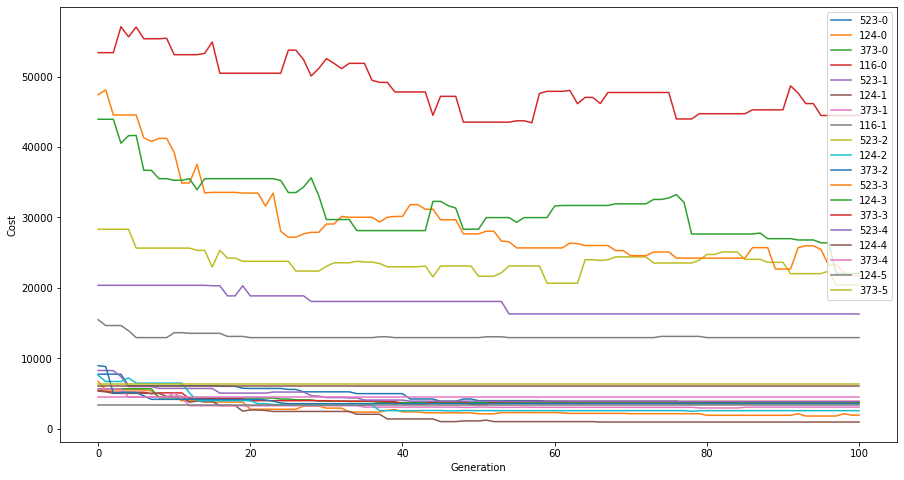

In [249]:
plt.figure(figsize=(15,8))
for dep in mydict:
    process=[]
    for cost in mydict[dep]:
        process.append(cost)
    if len(mydict[dep]) > 0:
        plt.plot(process,label=dep);
plt.ylabel('Cost')
plt.xlabel('Generation')
plt.legend()
plt.show()

**Graph for each lorry:** Cost vs Generation

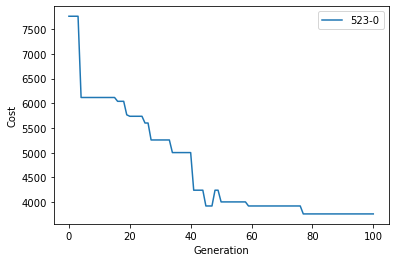

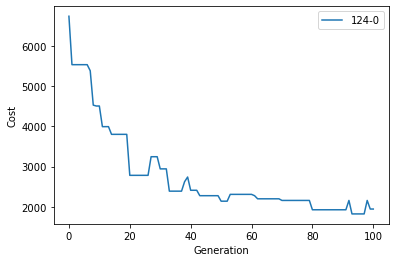

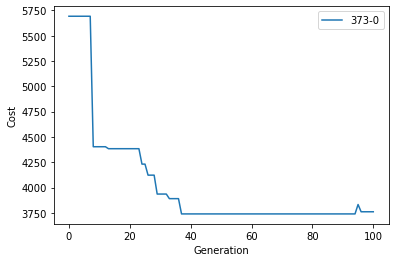

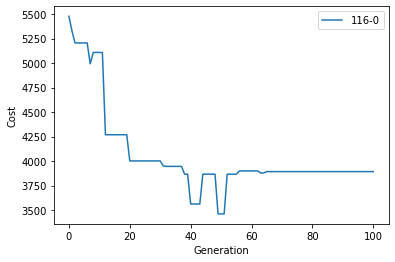

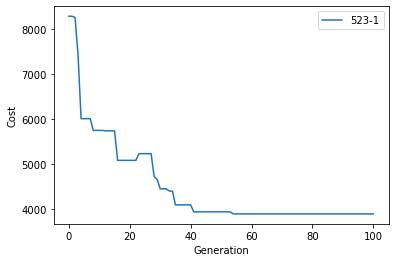

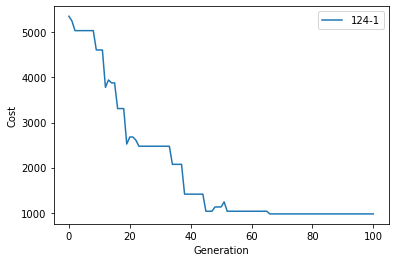

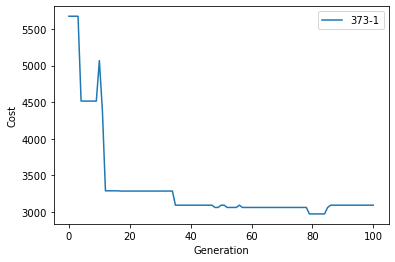

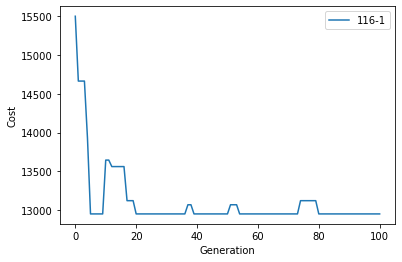

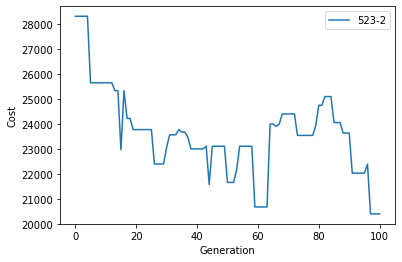

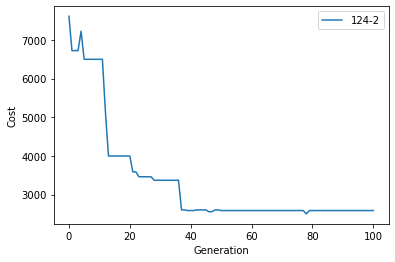

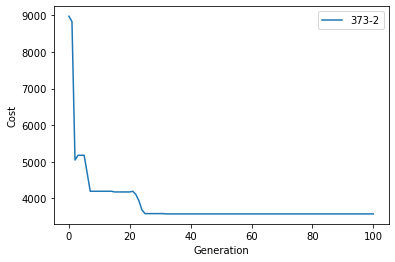

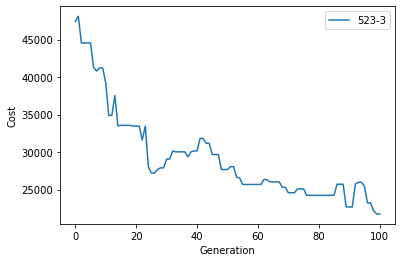

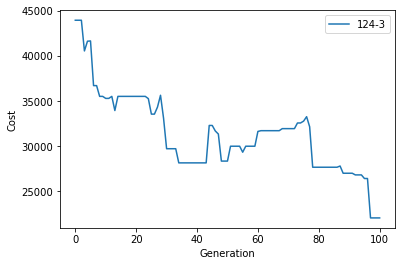

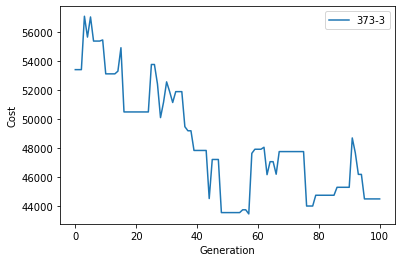

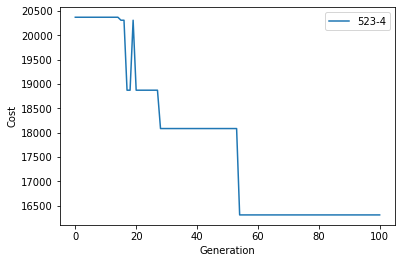

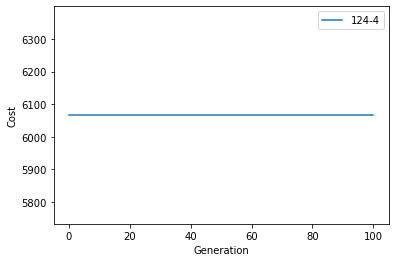

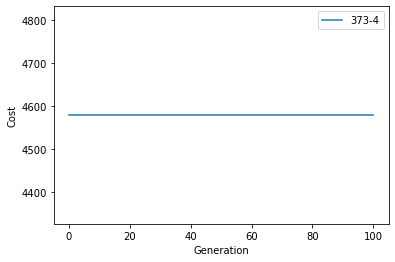

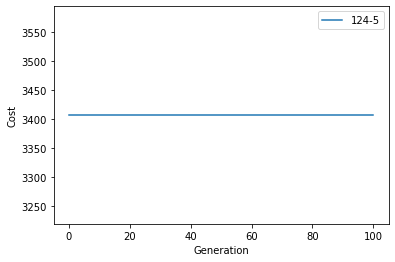

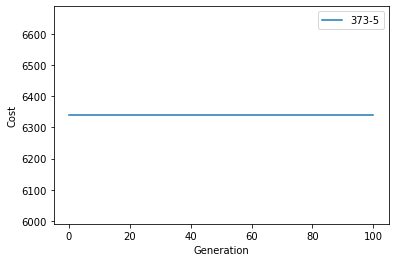

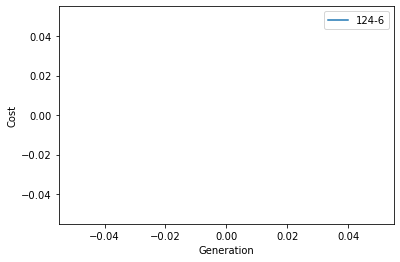

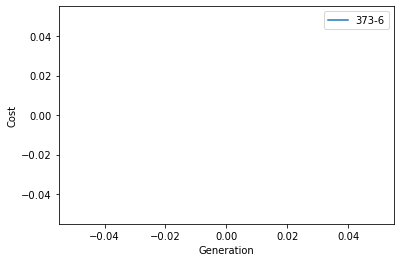

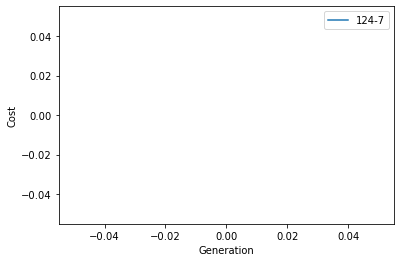

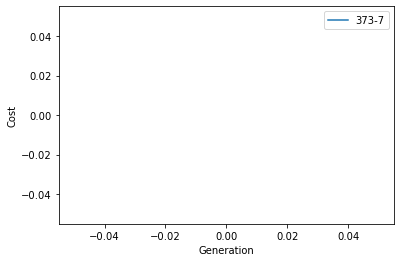

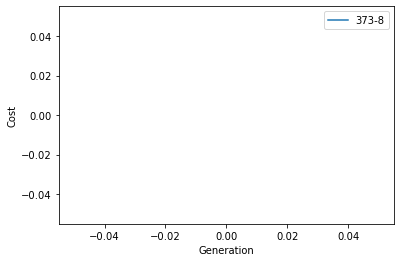

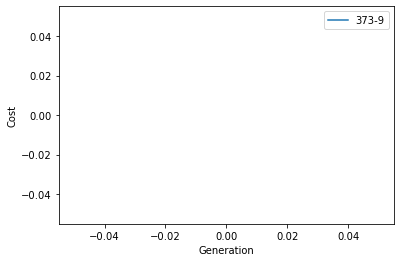

In [250]:
for dep in mydict:
    process=[]
    for cost in mydict[dep]:
        process.append(cost)
    plt.plot(process,label=dep);
    plt.ylabel('Cost')
    plt.xlabel('Generation')
    plt.legend()
    plt.show()

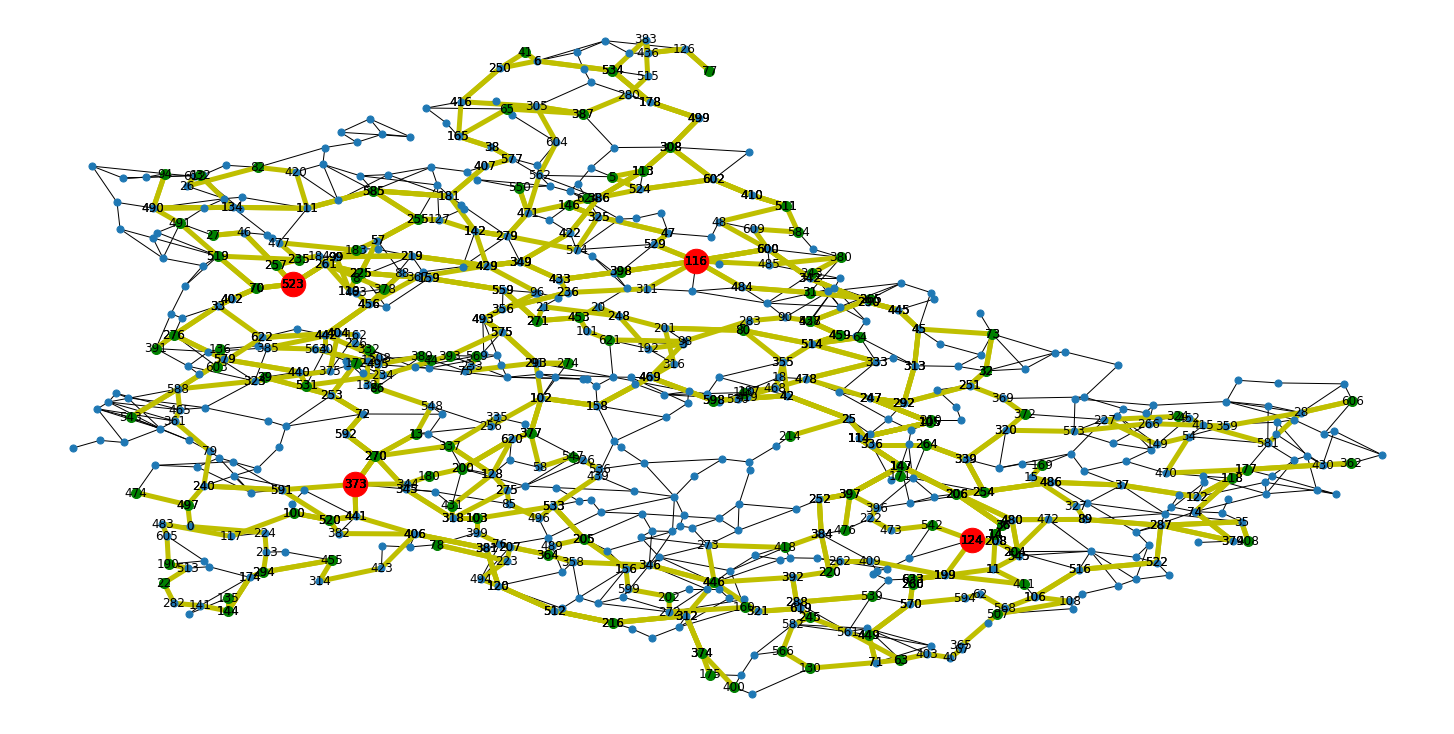

In [311]:
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=False,pos=pos,node_size=50)

nx.draw_networkx_nodes(G,pos,nodelist=depot_loc_ids,node_color='r',node_size=600,alpha=1);
nx.draw_networkx_labels(G,pos,{k:k for k in depot_loc_ids});
nx.draw_networkx_nodes(G,pos,nodelist=cust_loc_ids,node_color='g',node_size=100,alpha=1);
nx.draw_networkx_labels(G,pos,{k:k for k in sortpath});
with open('185783.54753191042.json') as json_file:
    data = json.load(json_file)
    for lorry in data:
        path=[]
        
        for index,location in enumerate(lorry['loc']):            
            if index < len(lorry['loc']) -2:
                path =path + nx.shortest_path(G,source=location[0],target=lorry['loc'][index+1][0])
#         for index,each in enumerate(path):
#             if index ==0:
#                 distance = nx.shortest_path(G,source=each,target=each[index+1])
#             elif index < len(path)-2:
#                 distance =distance + nx.shortest_path(G,source=each[index],target=each[index+1])
        sp_edges= list(zip(path,path[1:]))
        nx.draw_networkx_labels(G,pos,{k:k for k in path});
        nx.draw_networkx_edges(G,pos,edgelist=sp_edges,edge_color='y',width=5)

# **Greedy Search:**

To compare with genetic algorithm we use simple greedy search

In [101]:
clearAll()

In [102]:
loadFiles()

In [103]:
initializeGlobelVariable()


In [61]:
# This function is use to divide the customer in each customer list
def dividecustomer():
    
    allcustomer=squareform(pdist(df_loc[['x', 'y']]))
    capacity_523= totalCapacity(523)
    capacity_124= totalCapacity(124)
    capacity_373= totalCapacity(373)
    capacity_116= totalCapacity(116)
    global cust_523,cust_124,cust_373,cust_116
    for customer in cust_loc_ids:
        requirement= float(df_loc.loc[[int(customer)]].capacity) - float(df_loc.loc[[int(customer)]].level)
        my_dict = my_dictionary()
        if capacity_523-requirement >0:
            my_dict.add(523, allcustomer[customer,523]) 
            capacity_523=capacity_523-requirement
        if capacity_124-requirement >0:
            my_dict.add(124, allcustomer[customer,124]) 
            
        if capacity_373-requirement >0:
            my_dict.add(373, allcustomer[customer,373]) 
           
        if capacity_116-requirement >0:
            my_dict.add(116, allcustomer[customer,116]) 
           
           

        
#         min_cust = [allcustomer[customer,523], allcustomer[customer,124], allcustomer[customer,373], allcustomer[customer,116]]
        index= min(my_dict.keys(), key=(lambda k: my_dict[k])) # Given customer is near by which depot
        if index == 523:
            cust_523.append(customer)   
            capacity_523=capacity_523-requirement
        elif index ==116:
            cust_116.append(customer)
            capacity_116=capacity_116-requirement
        elif index == 124:
            cust_124.append(customer)
            capacity_124=capacity_124-requirement
        else:
            cust_373.append(customer)
            capacity_373=capacity_373-requirement

In [62]:
def sortestPath(number,depot):
    global dist_graph
#     if depot == 523:
#         customer_list=cust_523
#     elif depot ==116:
#         customer_list=cust_116
#     elif depot == 124:
#         customer_list=cust_124
#     else:
#         customer_list=cust_373
#     if len(customer_list) == 0:
#         return 0
    customer = dist_graph[number,:].argsort()[0] # next stop for lorry should be near by current stop
    if dist_graph[number,customer] >=5000:
        return 0
    else:
        return customer

In [106]:
def getSortestCustomer():
    global remainingCustomer
    global AllCustomerDistance,dist_graph;
    global cust_523,cust_116,cust_124,cust_373
    totalcost=0
    ans=[]
    for limit in range(0,11):
        for e in depot_lorries.items():
            route=[]
            pathCost =0
            if(len(e[1]) > limit):
                customerVisited=[]
                
                each=e[1][limit]  
                
                locationnumber = int(e[0])
                lorry=Lorry(_id= each['lorry_id'],key=locationnumber,
                                                     capacity=int(each['capacity']),
                                                     cpm=float(each['cpm']),
                                                     cptm= float(each['cptm']),
                                                     loaded=int(each['capacity']))

                customerVisited.append([locationnumber,int(each['capacity'])])
#                 print("Capacity =>" +str(each['capacity']))
                while lorry.loaded > 0.20 and len(remainingCustomer) >0: # #REPEAT UNTILL ( Lorry has capacity)
                    nextlocation = sortestPath(locationnumber,int(e[0]))
            
                    print("nextlocation =>" +str(nextlocation))
                    
                    if df_loc.loc[locationnumber].is_depot == True and len(route) ==0:
                        route.append(locationnumber)
                        fromlocation= Customer(_id=df_loc.loc[locationnumber].id,x=df_loc.loc[locationnumber].x, y=df_loc.loc[locationnumber].y, capacity=0.0, level=0.0)
                    else:
                        fromlocation= Customer(_id=df_loc.loc[locationnumber].id,x=df_loc.loc[locationnumber].x, y=df_loc.loc[locationnumber].y, capacity=df_loc.loc[locationnumber].capacity, level=df_loc.loc[locationnumber].level)
                    #Find valid next customer
                    while df_loc.loc[nextlocation].is_customer != True or not nextlocation in remainingCustomer:
                        dist_graph[locationnumber,nextlocation] =5000
                        dist_graph[nextlocation,locationnumber] =5000
                        nextlocation = sortestPath(locationnumber,int(e[0]))
                        if nextlocation == 0:
                            break;
                    if nextlocation == 0:
                        break;

                    tolocation= Customer(_id=df_loc.loc[nextlocation].id,x=df_loc.loc[nextlocation].x, y=df_loc.loc[nextlocation].y, capacity=df_loc.loc[nextlocation].capacity, level=df_loc.loc[nextlocation].level)
                    lorry.remaining_loaded(tolocation.required)
                    pathCost += lorry.cost(fromlocation.distance(tolocation))                 
                     
                    if lorry.loaded > 0 and nextlocation in remainingCustomer:
                        pathCost += lorry.cost(fromlocation.distance(tolocation)) 
                        dist_graph[locationnumber,nextlocation] =5000
                        dist_graph[nextlocation,locationnumber] =5000
                        route.append(nextlocation)
                        customerVisited.append([nextlocation,float(tolocation.required) - (2 * float(tolocation.required))])
                        locationnumber = nextlocation
                        remainingCustomer=markVisited(nextlocation)
#                         if int(e[0]) == 523:
#                             cust_523.remove(int(nextlocation))
#                         elif int(e[0]) ==116:
#                             cust_116.remove(int(nextlocation))
#                         elif int(e[0]) == 124:
#                             cust_124.remove(int(nextlocation))
#                         else:
#                             cust_373.remove(int(nextlocation))
                    else:
                        break
                print("customerVisited =>" + str(customerVisited))
                customerVisited.append([depot_loc_ids[dist_graph[locationnumber,depot_loc_ids].argsort()[0]],0])
                ans.append({"lorry_id": each['lorry_id'], "loc": customerVisited})
            totalcost = totalcost +pathCost
            print("Cost=> "+ str(pathCost))
#             print("Route =>" + str(route))

    print("totalcost=> "+ str(totalcost))
    print("ans=>" + str(ans))
    createJSONFile(str(ans).replace('\'','"'),totalcost)
    return ans

In [107]:
dividecustomer()

In [108]:
%%time
getSortestCustomer()

nextlocation =>523
nextlocation =>70
nextlocation =>519
nextlocation =>491
nextlocation =>27
nextlocation =>257
nextlocation =>235
nextlocation =>183
nextlocation =>225
customerVisited =>[[523, 5], [70, -1.46], [519, -0.21000000000000002], [491, -0.33999999999999997], [27, -1.02], [257, -0.19999999999999996], [235, -0.36], [183, -0.3999999999999999], [225, -0.64], [8, -0.19999999999999996]]
Cost=> 2308.456765563876
nextlocation =>124
nextlocation =>14
nextlocation =>36
nextlocation =>204
nextlocation =>411
nextlocation =>507
nextlocation =>63
customerVisited =>[[124, 5], [14, -0.32999999999999996], [36, -0.81], [204, -0.69], [411, -0.99], [507, -1.15], [63, -0.47]]
Cost=> 1864.6519762800733
nextlocation =>373
nextlocation =>270
nextlocation =>13
nextlocation =>337
nextlocation =>200
nextlocation =>180
nextlocation =>431
nextlocation =>103
nextlocation =>78
nextlocation =>364
customerVisited =>[[373, 5], [270, -0.21999999999999997], [13, -0.19999999999999996], [337, -0.44999999999999996

File save as 134223.8233358213.json
Wall time: 1.13 s


[{'lorry_id': '523-0',
  'loc': [[523, 5],
   [70, -1.46],
   [519, -0.21000000000000002],
   [491, -0.33999999999999997],
   [27, -1.02],
   [257, -0.19999999999999996],
   [235, -0.36],
   [183, -0.3999999999999999],
   [225, -0.64],
   [8, -0.19999999999999996],
   [523, 0]]},
 {'lorry_id': '124-0',
  'loc': [[124, 5],
   [14, -0.32999999999999996],
   [36, -0.81],
   [204, -0.69],
   [411, -0.99],
   [507, -1.15],
   [63, -0.47],
   [124, 0]]},
 {'lorry_id': '373-0',
  'loc': [[373, 5],
   [270, -0.21999999999999997],
   [13, -0.19999999999999996],
   [337, -0.44999999999999996],
   [200, -0.27],
   [180, -0.76],
   [431, -0.39],
   [103, -0.43999999999999995],
   [78, -0.63],
   [364, -0.89],
   [373, 0]]},
 {'lorry_id': '116-0',
  'loc': [[116, 5],
   [398, -0.89],
   [453, -0.61],
   [271, -0.9],
   [621, -0.24],
   [80, -0.22999999999999998],
   [528, -0.12],
   [437, -0.94],
   [116, 0]]},
 {'lorry_id': '523-1',
  'loc': [[523, 5],
   [276, -0.9299999999999999],
   [391, -1.0]

# **Testing:**

In [54]:
loadFiles()

In [55]:
initializeGlobelVariable()


In [58]:
with open('98833.36029570161.json') as json_file:
    js = json.load(json_file)
    data=json.loads((js))
    totalcost=0
    for lorry in data:
        path=[]
        cpm=0
        cptm=0
        capacity=0
        cost=0
        for d in depot_lorries:
            for e in depot_lorries[d]:
                for key,value in e.items():
                    if value ==lorry['lorry_id']:
                        cpm=e['cpm']
                        cptm=e['cptm']
                        capacity=e['capacity']
        
        for index,location in enumerate(lorry['loc']):            
            if index < len(lorry['loc'])-1:
                if df_loc.loc[location[0]].is_customer == True:
                    capacity = capacity - (df_loc.loc[location[0]].capacity - df_loc.loc[location[0]].level)
                    
                cost = cost + ((dist_graph[location[0],lorry['loc'][index+1][0]]) * (cpm + (capacity * cptm)))
                path.append(location[0])
                
        print("Cost => " + str(cost))
        print("Path => " + str(path))
        totalcost=totalcost+cost
    print("total cost= >"+ str(totalcost))
       

Cost => 1570.1078082575018
Path => [523, 70, 94, 632, 235, 183]
Cost => 1500.6453632527507
Path => [124, 204, 260, 449]
Cost => 2414.1786717017194
Path => [373, 180, 377, 547, 110]
Cost => 1538.5546669735418
Path => [116, 459, 64, 437, 528, 265]
Cost => 2662.493352673503
Path => [523, 27, 585, 146, 398]
Cost => 1581.029831266543
Path => [124, 254, 171, 147]
Cost => 2710.1844153596944
Path => [373, 172, 29, 391, 276, 603, 136]
Cost => 6616.041074257011
Path => [116, 453, 621, 31, 380, 584, 511]
Cost => 11057.00800016239
Path => [523, 332, 393, 44, 389, 86, 543, 497, 22, 190, 100, 364, 205, 598, 271]
Cost => 1933.6215421908107
Path => [124, 14, 36, 169, 372]
Cost => 3622.819147543449
Path => [373, 78, 446, 175, 130]
Cost => 17777.63405979941
Path => [523, 225, 550, 624, 113, 5, 308, 534, 65, 41, 387, 243, 32, 80, 255, 519, 491, 378, 8, 257, 82, 337, 569, 274]
Cost => 9498.339622941905
Path => [124, 542, 476, 397, 264, 105, 214, 206, 411, 507, 177, 118, 362, 220, 418]
Cost => 21303.183383

# **Comparision:**

| Units | Greedy Search | Genetic Algorithms 100 Generation | Genetic Algorithms 500 Generation |
| --- | --- | --- | --- |
| Total Cost | 71586.06 | 152689.24781383647 | 133003.91649820274 |
| Time (Second) | 1.3 | 153 | 655 |
| Gas Delivered | 90.42 | 90.42 | 90.42 |

# **Conclusion:**
For above solution, we have used both greedy and genetic algorithms but as we can see in above table greedy algorithms gives better output here.

* Genetic algorithms is good in routing problem where starting point and ending point are cleared.
* Genetic algorithms also used in routing problem where routes are not fixed or changing frequently.
* Genetic algorithms work good when we have given a list of customer but accuracy decrease with number of customer decrease.

Ex. If there is 20 customer in list for 523-0. We can see our optimization algorithm work good but once this list decrease the algorithm dont have any differnt individual in population to perfom cross over and mutation.

# **References:**

[1] 	E. Stoltz, "Evolution of a salesman: A complete genetic algorithm tutorial for Python," 17 07 2018. [Online]. Available: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35. [Accessed 25 10 2020].

[2] 	A. G. Najera, "Multi-Objective Evolutionary Algorithms," 11 2010. [Online]. Available: https://etheses.bham.ac.uk//id/eprint/1069/1/GarciaNajera_10_PhD.pdf. [Accessed 15 11 2020].

[3] 	M. Allen, "Python for healthcare modelling and data science," 01 10 2018. [Online]. Available: Genetic algorithms 1. A simple genetic algorithm. [Accessed 29 10 2020].

[4] 	Y. Sharma and S. C. S. a. M. Bhandhari, "Comparison of Dijkstra’s Shortest Path Algorithm with," [Online]. Available: https://core.ac.uk/download/pdf/25713636.pdf. [Accessed 29 12 2020].

[5] 	D. S. P. S. Aric Hagberg, "NetworkX Reference," [Online]. Available: https://networkx.org/documentation/latest/_downloads/networkx_reference.pdf. [Accessed 14 01 2021].


